## loading annotation data

In [2]:
import json

with open('annotation-results.json', 'r') as f:
    data = json.load(f)

data[100], len(data)

({'metadata': "Strategy: Avoid Judgment and Criticism<br><br>Description: This strategy focuses on providing support without expressing negative judgments or criticisms of the person's thoughts, feelings, or actions. Examples: 'It's understandable that you felt that way in that situation.' 'Everyone makes mistakes, and it's okay to be imperfect.' 'Your feelings are valid, and it's okay to express them.'",
  'conv_id': '3a201760-ce3b-49f6-9e72-97807d66452b_Avoid Judgment and Criticism',
  'file_names': ['prompting/outputs/exp6_70b_full//46.json',
   'prompting/outputs/exp6_70b_c1_hf_partial//46.json'],
  'history': "<br><b>seeker</b>: hello<br><b>supporter</b>: Hi, how are you today?<br><b>seeker</b>: could be better\n how are u<br><b>supporter</b>: I'm sorry you're not feeling great, what's wrong?<br><b>seeker</b>: i cant afford a house<br><b>supporter</b>: I'm sorry to hear that, we're in hard times right now for sure.<br><b>seeker</b>: Ya I am barely making it through Christmas and s

## collect SRA and scores

In [52]:
import pandas as pd
import numpy as np

scores = []
SRA_diffs = []
comp_types = []
annotators = []
ids = []

def get_model_type_from_filename(fname):
    if '70b_full' in fname:
        return 'standard'
    elif 'c1_hf_partial' in fname:
        return 'c1_hf'
    elif 'c3_hf_partial' in fname:
        return 'c3_hf'
    else:
        raise Exception("model type was not in the annotation task")
    

for d in data:
    scores.append(int(d['model-preference']))
    SRA_diffs.append(float(d['model2_sra']-d['model1_sra']))

    annotators.append(d['annotator'])
    ids.append(d['conv_id'])
    m1_filename = d['file_names'][0]
    m2_filename = d['file_names'][1]
    comp_types.append(f"{get_model_type_from_filename(m1_filename)}-vs-{get_model_type_from_filename(m2_filename)}")

df = pd.DataFrame({'score': scores, 'SRA-diff': SRA_diffs, 'compared models': comp_types, 'annotator': annotators, 'id':ids})
df['SRA-diff'] = (df['SRA-diff']-df['SRA-diff'].mean())/df['SRA-diff'].std()
df['score'] = (df['score']-df['score'].mean())/df['score'].std()

df

,score,SRA-diff,compared models,annotator,id
0,-1.453667,-0.643734,c1_hf-vs-c3_hf,1,7b0776d1-6282-44bf-8958-c33e8862ac1b_Reframe N...
1,-0.384675,0.556693,c3_hf-vs-c1_hf,1,a931df13-0d52-4003-b217-d83e6c926bb8_Share Inf...
2,0.327986,1.163829,c3_hf-vs-c1_hf,1,a038253f-ffa1-457c-9ad1-2f6c8c74f2d5_Share Inf...
3,1.396978,1.385172,c3_hf-vs-c1_hf,1,c5f66963-be9f-44b1-9db7-e2e264e38de6_Stress Ma...
4,-0.028344,-0.915719,c1_hf-vs-c3_hf,1,0bd0ca08-ab35-4608-8f95-a70bfe3704d1_Promote S...
...,...,...,...,...,...
259,-0.028344,0.426354,standard-vs-c3_hf,2,92a62a9c-7cf3-4982-8ad4-90acced1add5_Share Inf...
260,-1.453667,-0.820451,c3_hf-vs-standard,1,c8d49ced-3406-4646-883e-aeec07005a53_Promote S...
261,-1.453667,-0.820451,c3_hf-vs-standard,2,c8d49ced-3406-4646-883e-aeec07005a53_Promote S...
262,0.684317,0.126976,standard-vs-c3_hf,1,e66c769a-758f-44c4-b1c7-0e688f92c35f_Suggest O...


In [53]:
def remove_outliers_percentile(df, column_name):
    # Calculate the 1st and 99th percentiles
    P1 = df[column_name].quantile(0.01)
    P99 = df[column_name].quantile(0.99)
    
    # Filter out outliers outside the 1st and 99th percentiles
    filtered_df = df[(df[column_name] >= P1) & (df[column_name] <= P99)]
    
    return filtered_df

cleaned_df = remove_outliers_percentile(df, 'SRA-diff')
cleaned_df


,score,SRA-diff,compared models,annotator,id
0,-1.453667,-0.643734,c1_hf-vs-c3_hf,1,7b0776d1-6282-44bf-8958-c33e8862ac1b_Reframe N...
1,-0.384675,0.556693,c3_hf-vs-c1_hf,1,a931df13-0d52-4003-b217-d83e6c926bb8_Share Inf...
2,0.327986,1.163829,c3_hf-vs-c1_hf,1,a038253f-ffa1-457c-9ad1-2f6c8c74f2d5_Share Inf...
3,1.396978,1.385172,c3_hf-vs-c1_hf,1,c5f66963-be9f-44b1-9db7-e2e264e38de6_Stress Ma...
4,-0.028344,-0.915719,c1_hf-vs-c3_hf,1,0bd0ca08-ab35-4608-8f95-a70bfe3704d1_Promote S...
...,...,...,...,...,...
259,-0.028344,0.426354,standard-vs-c3_hf,2,92a62a9c-7cf3-4982-8ad4-90acced1add5_Share Inf...
260,-1.453667,-0.820451,c3_hf-vs-standard,1,c8d49ced-3406-4646-883e-aeec07005a53_Promote S...
261,-1.453667,-0.820451,c3_hf-vs-standard,2,c8d49ced-3406-4646-883e-aeec07005a53_Promote S...
262,0.684317,0.126976,standard-vs-c3_hf,1,e66c769a-758f-44c4-b1c7-0e688f92c35f_Suggest O...


In [54]:
grouped_mean = cleaned_df.groupby('id')[['score', 'SRA-diff']].mean().reset_index()
grouped_mean

,id,score,SRA-diff
0,005531ec-74de-4d81-a914-ce9296647df2_Share Inf...,-0.028344,-0.357073
1,013a556f-bad0-4ef2-b146-64b4656bedf7_Affirmation,1.396978,0.716957
2,040be129-f64e-4fd7-94db-ab7176299ab0_Collabora...,-0.206510,0.643510
3,041358ce-4e42-484c-a1c5-bba77f601670_Collabora...,-0.206510,0.367203
4,060971ec-cebc-4cf4-92a2-167e62dc533c_Emotional...,-0.919171,-1.132981
...,...,...,...
128,f62d16da-a3d8-49a9-b0fd-edefa464a170_Chit Chat,1.218813,1.135819
129,f89d70f8-26ed-482e-a650-ef22b04d9b2f_Emotional...,0.506152,0.354343
130,fbcbc26d-f71b-420f-8b48-13630829a677_Stress Ma...,-0.741006,-1.232785
131,fcfe46bb-aaf2-44ea-8212-f25dd24d96c7_Normalize...,1.218813,0.658182


<Axes: xlabel='SRA-diff', ylabel='score'>

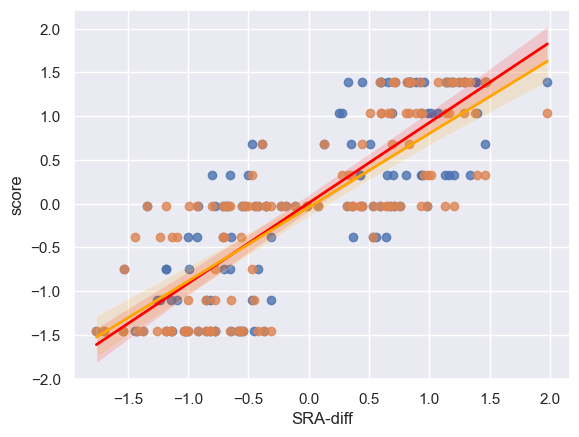

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

ann1_df = cleaned_df[cleaned_df['annotator']==1]
ann2_df = cleaned_df[cleaned_df['annotator']==2]

sns.set_theme()
# sns.regplot(grouped_mean, x='SRA-diff', y='score', line_kws={'color': 'orange', 'lw': 2})
sns.regplot(ann1_df, x='SRA-diff', y='score', line_kws={'color': 'red', 'lw': 2})
sns.regplot(ann2_df, x='SRA-diff', y='score', line_kws={'color': 'orange', 'lw': 2})


In [64]:
from scipy.stats import pearsonr


correlation, p_value = pearsonr(ann1_df['SRA-diff'], ann1_df['score'])

print(f'Pearson correlation coefficient: {correlation}')

correlation, p_value = pearsonr(ann2_df['SRA-diff'], ann2_df['score'])

print(f'Pearson correlation coefficient: {correlation}')

Pearson correlation coefficient: 0.8221829783610995
Pearson correlation coefficient: 0.8035292893330965
